# Poker Hand

Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. There is one Class attribute that describes the "Poker Hand". The order of cards is important, which is why there are 480 possible Royal Flush hands as compared to 4

https://archive.ics.uci.edu/ml/datasets/Poker+Hand

In [71]:
import numpy as np 

import pandas as pd 
import warnings 
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
import time
import plotly.express as px

from sklearn.metrics import accuracy_score, precision_score, f1_score

from sklearn.model_selection import KFold,cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [23]:
col_names = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5', 'Class']
# ['Nothing','One pair','Two  pair','Three of a kind','Straight','Flush','Full house','Four of a kind','Straight flush','Royal flush']


df = pd.read_csv('./poker-hand-training-true.data',sep=',',names=col_names)
df_test = pd.read_csv('./poker-hand-testing.data',sep=',',names=col_names)

In [18]:
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [63]:
hand=df.values
Y=hand[:,-1]
X=hand[:,:10]
np.shape(df)

(25010, 11)

In [64]:
fig = px.histogram(Y,category_orders=dict(day=["Thur", "Fri", "Sat", "Sun"]))
fig.show()

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.5, random_state=0)

### Evaluation de Modèle


In [78]:
def score(Y_train,Y_test,X_train,X_test):
    CART = DecisionTreeClassifier(random_state=1)
    CART.fit(X_train,Y_train)
    neigh = KNeighborsClassifier(n_neighbors=5)
    KNN=neigh.fit(X_train, Y_train)
#     print("Cart accuracy:",accuracy_score(Y_test , CART.predict(X_test)))
    print("Cart f1_score:",f1_score(Y_test , CART.predict(X_test),average = 'micro'))
#     print("Cart precision_score:",precision_score(Y_test , CART.predict(X_test),average = 'micro'))
#     print("KNN accuracy:",accuracy_score(Y_test, KNN.predict(X_test)))
    print("KNN f1_score:",f1_score(Y_test, KNN.predict(X_test),average = 'micro'))
#     print("KNN precision_score:",precision_score(Y_test, KNN.predict(X_test),average = 'micro'))

score(Y_train,Y_test,X_train,X_test)   
    

Cart f1_score: 0.4926829268292683
KNN f1_score: 0.5406637345061975


#### NORMALISER LES DONNEES

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)

X2_train = scaler.transform(X_train)
X2_test = scaler.transform(X_test)

In [80]:
scaler2 = MinMaxScaler()

scaler2.fit(X_train)
X4_train = scaler2.transform(X_train)
X4_test = scaler2.transform(X_test)

#### EVALUATION DONNEES NORMALISE

In [81]:
score(Y_train,Y_test,X2_train,X2_test)  

Cart f1_score: 0.4920431827269092
KNN f1_score: 0.5088364654138344


### ACP

In [82]:
pca = PCA(n_components=3)
pca.fit(X_train)
print(pca.explained_variance_ratio_) 
X3_train = pca.transform(X_train)
X3_test = pca.transform(X_test)
X3_train=np.concatenate((X_train,X3_train),axis=1)
X3_test=np.concatenate((X_test,X3_test),axis=1)

[0.18962437 0.18844002 0.18478028]


In [83]:
score(Y_train,Y_test,X3_train,X3_test) 

Cart f1_score: 0.493562574970012
KNN f1_score: 0.5561775289884047


### Selection de Variables

['C3' 'C5' 'C4' 'C1' 'C2' 'S3' 'S4' 'S1' 'S5' 'S2']


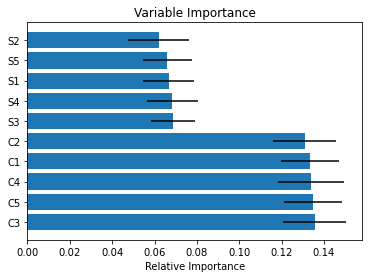

In [84]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,Y_train) 
importances=clf.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0) 
 
sorted_idx = np.argsort(importances)[::-1] 
 
features =df.columns.values
print(features[sorted_idx]) 
 
padding = np.arange(X_train.size/len(X_train)) + 0.5  
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')  
plt.yticks(padding, features[sorted_idx])  
plt.xlabel("Relative Importance") 
plt.title("Variable Importance")  
plt.show() 

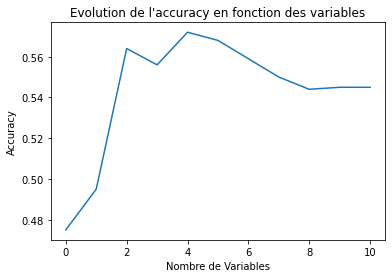

In [85]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(X_train.shape[1]+1)
for f in np.arange(0, X_train.shape[1]+1):
    X1_f = X_train[:,sorted_idx[:f+1]]
    X2_f = X_test[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,Y_train)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(Y_test,YKNN),3) 

plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

### Paramétrage des classifieurs

In [109]:
parameters_cart = {'criterion':["gini","entropy"],"max_depth":[1,2,3,4,5,6,7,8]}
CART = DecisionTreeClassifier(random_state=1)
cartp= GridSearchCV(CART, parameters_cart, cv=10)
print("CART param:" ,cartp.fit(X_train, Y_train).best_params_)

parameters_knn = {'n_neighbors':range(20)}
KNN = KNeighborsClassifier(n_neighbors=5)
knnp= GridSearchCV(KNN, parameters_knn, cv=10)
print("KNN param:" ,knnp.fit(X_train, Y_train).best_params_)

CART param: {'criterion': 'entropy', 'max_depth': 6}
KNN param: {'n_neighbors': 16}


### Création d’un pipeline

In [112]:
Pipe_cart=Pipeline([('cart',DecisionTreeClassifier(random_state=1))])
Pipe_cart.fit(X_train,Y_train)
print("Cart accuracy:",accuracy_score(Y_test , Pipe_cart.predict(X_test)))
# print("Cart f1_score:",f1_score(Y_test , Pipe_cart.predict(X_test),average='micro'))

Pipe_knn=Pipeline([('knn',KNeighborsClassifier(n_neighbors=16))])
Pipe_knn.fit(X_train,Y_train)
print("Knn accuracy:",accuracy_score(Y_test , Pipe_knn.predict(X_test)))
# print("Knn f1_score:",f1_score(Y_test , Pipe_knn.predict(X_test),average='micro'))


Cart accuracy: 0.4926829268292683
Knn accuracy: 0.5645741703318673


### Comparaison d'algos

In [113]:
clfs = {
 'RF': RandomForestClassifier(n_estimators=50),
 'KNN': KNeighborsClassifier(n_neighbors=5), 
 'NB' : GaussianNB(),
 'CART': DecisionTreeClassifier(random_state=1),
 'MLP': MLPClassifier(alpha=1),
 'AB': AdaBoostClassifier(n_estimators=50),
 'BG': BaggingClassifier(n_estimators=50),
 'ID3': DecisionTreeClassifier(random_state=1,criterion="entropy"),
 'SP': DecisionTreeClassifier(random_state=1,max_depth=1)
}

def run_classifiers(clfs,X,Y):
    kf10 = KFold(n_splits=10, shuffle=True, random_state=0)
    kf5 = KFold(n_splits=5, shuffle=True, random_state=0)
    for i in clfs:
        clf = clfs[i]
        t=time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf10)
        cv_auc = cross_val_score(clf, X, Y, cv=kf10, scoring='roc_auc')
        cv_rec = cross_val_score(clf, X, Y, cv=kf5, scoring='recall')
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_acc), np.std(cv_acc)))
        print("Time for {0} is: {1:.2f}".format(i,time.time()-t))
        print()
run_classifiers(clfs,X,Y)

Accuracy for RF is: 0.601 +/- 0.012
AUC for RF is: nan +/- nan
Recall for RF is: nan +/- nan
Time for RF is: 26.35

Accuracy for KNN is: 0.547 +/- 0.010
AUC for KNN is: nan +/- nan
Recall for KNN is: nan +/- nan
Time for KNN is: 3.88

Accuracy for NB is: 0.493 +/- 0.018
AUC for NB is: nan +/- nan
Recall for NB is: nan +/- nan
Time for NB is: 0.22

Accuracy for CART is: 0.490 +/- 0.015
AUC for CART is: nan +/- nan
Recall for CART is: nan +/- nan
Time for CART is: 1.84

Accuracy for MLP is: 0.633 +/- 0.016
AUC for MLP is: nan +/- nan
Recall for MLP is: nan +/- nan
Time for MLP is: 300.77

Accuracy for AB is: 0.492 +/- 0.017
AUC for AB is: nan +/- nan
Recall for AB is: nan +/- nan
Time for AB is: 16.05

Accuracy for BG is: 0.622 +/- 0.008
AUC for BG is: nan +/- nan
Recall for BG is: nan +/- nan
Time for BG is: 57.80

Accuracy for ID3 is: 0.500 +/- 0.019
AUC for ID3 is: nan +/- nan
Recall for ID3 is: nan +/- nan
Time for ID3 is: 1.99

Accuracy for SP is: 0.500 +/- 0.012
AUC for SP is: nan 

In [126]:
parameter_space = {
'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1, 1],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier()
mlpp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=10)
print("MLP param:" ,mlpp.fit(X_train, Y_train).best_params_)

KeyboardInterrupt: 

In [125]:

MLP = MLPClassifier(alpha=1,
                    activation = 'tanh',
                    learning_rate= 'constant',
                    solver= 'adam',
                    random_state=1)
MLP.fit(X_train, Y_train)
print("MLP f1_score:",f1_score(Y_test, MLP.predict(X_test),average = 'micro'))

MLP f1_score: 0.5884046381447421
